## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
import inspect
print(os.getcwd())
plot_folder = '3d_arm_dyn_plots'

In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
parent_dir

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc'

In [4]:
# change dir to import from aesmc
os.chdir(parent_dir)
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
import aesmc.smoothing as smoothing

In [5]:
# change dir to import from aesmc/test
os.chdir(current_dir)
from arm_models import arm_3d_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import proposal_objects
import Datasets

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [7]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [8]:
# running params
num_timesteps = 100 # of original signal, we may interpolate below.
saving_interval = 10
logging_interval = 10
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

### Load and organize data.
#### From it, get a sense for model inits.
This 3D data is a result of running a Bundle Adjustment Algorithm on the 2D tracked points from two cameras. We are analyzing a session from Sep-15 2019.
#### ToDo: 
we'll need to annotate which image is the first one in the BA_array. IIRC its 4500:, so $9610 - 4500 = 5110$ but need to verify

In [9]:
#os.getcwd()
BA_array = arm_utils.load_object(
    os.path.join(os.getcwd(), 'datasets', 'Costa-3D-09-15-19',
                 'BA_3D_pts_costa-09-15-19'))
print(BA_array.shape)

(9, 5110)


In [89]:
def center_3D_coords(sliced, use_mean = True):
    if use_mean:
        x_offset = np.nanmean(sliced[:,0])
        y_offset = np.nanmean(sliced[:,1])
        z_offset = np.nanmean(sliced[:,2])
        temp = [x_offset,y_offset,z_offset]
        temp_tile = np.tile(temp,3)
    else: 
        x_offset = sliced[:,0]
        y_offset = sliced[:,1]
        z_offset = sliced[:,2]
        temp = np.array([x_offset,y_offset,z_offset]).T
        temp_tile = np.tile(temp,(1,3))
    
    data_centered = np.copy(sliced)
    data_centered = data_centered - temp_tile
    
    if use_mean == False:
        assert((data_centered[:,0] == 0).all())
        assert((data_centered[:,1] == 0).all())
        assert((data_centered[:,2] == 0).all())
    
    return data_centered, (x_offset, y_offset, z_offset)

In [18]:
# use mean: subtract the mean coord. don't use mean: from each point, subtract the shoulder.
centered_arr, offset_tuple = arm_utils.center_3D_coords(BA_array.T, use_mean = False)
print(offset_tuple)
print(centered_arr.shape)
centered_arr = centered_arr.T
print(centered_arr.shape)

(array([-1.57415616, -1.57450542, -1.54046304, ..., -1.83157197,
       -1.84030805, -1.84312329]), array([-1.30853847, -1.30975844, -1.30475574, ..., -1.34547416,
       -1.34666778, -1.34693587]), array([3.26632846, 3.25352673, 3.26086879, ..., 3.21609795, 3.21512076,
       3.21606286]))
(5110, 9)
(9, 5110)


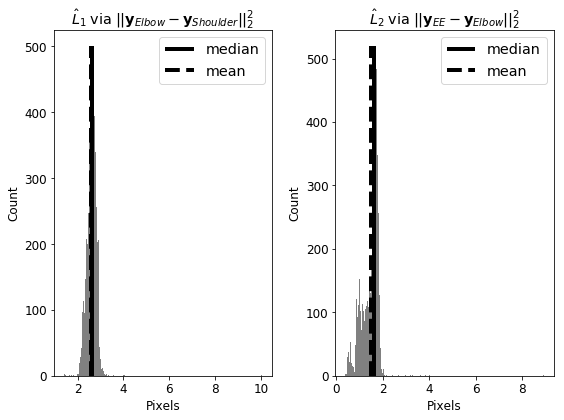

mean L1: 2.61, mean L2: 1.49 
median L1: 2.62, median L2: 1.61 


In [19]:
norm1, norm2 = arm_utils.compute_3D_norms(centered_arr.T)
arm_utils.plot_empirical_norms_hist(
    norm1, norm2, 200, os.path.join(plot_folder, 'empirical_norms'))
print("mean L1: %.2f, mean L2: %.2f " % (np.mean(norm1), np.mean(norm2)))
print("median L1: %.2f, median L2: %.2f " %(np.median(norm1), np.median(norm2)))

### Data loading

In [20]:
# re-organize data
desired_sampling_rate = 180.0
original_sampling_rate = 30.0
num_timesteps_desired = desired_sampling_rate / original_sampling_rate * centered_arr.shape[
    1]  # for the entire seq
interpolator = arm_utils.interpolate_dataset(centered_arr,
                                             original_sampling_rate)
interpolated_data = interpolator.interpolate_evaluate(
    num_timesteps_desired=num_timesteps_desired,
    desired_sampling_rate=desired_sampling_rate)
#np.sum(interpolator.timesteps_to_take==True) should be original centered_arr.shape[1]

In [102]:
# now define a dataloader. max_allowed_chunks will be equivalent to num_iterations_in_epoch
dataset_test = Datasets.Dataset(interpolated_data, num_timesteps = 50, max_allowed_chunks=5)
test_generator = torch.utils.data.DataLoader(dataset_test)
# print(dataset_test.num_valid_chunks)
# print(30 * dataset_test.num_valid_chunks)
# print(len(dataset_test))

In [103]:
# for epoch_iteration_idx, (observations, t_ind_start) in enumerate(test_generator):
#     print(epoch_iteration_idx)
#     print(len(observations))
#     print(t_ind_start)

In [104]:
observations, t_ind_start = next(iter(test_generator))
print(len(observations))
print(observations[2].shape)
print(t_ind_start)

50
torch.Size([1, 9])
tensor([2750])


In [55]:
# # convert single dataset to aesmc format and send to device (make sure it doesn't cause memory issues)
# ind_start = 170
# single_dataset_arr = centered_arr[:, ind_start:(ind_start + num_timesteps)]
# print(single_dataset_arr.shape)

In [56]:
# desired_sampling_rate = 180
# num_timesteps_desired = 180
# interpolator = arm_utils.interpolate_dataset(single_dataset_arr, 30.0)
# interpolated_data = interpolator.interpolate_evaluate(
#     num_timesteps_desired=num_timesteps_desired,
#     desired_sampling_rate=desired_sampling_rate)
# # see tests below. use interpolator.timesteps_to_take when selecting the timesteps in the actual video.
# # plt.plot([-3.0, 3.0], [-3.0, 3.0], 'k')
# # plt.scatter(single_dataset_arr[:, :np.sum(interpolator.timesteps_to_take==True)],
# #             interpolated_data[:, interpolator.timesteps_to_take])
# # print(single_dataset_arr[0, :np.sum(interpolator.timesteps_to_take==True)])
# # print(interpolated_data[0, interpolator.timesteps_to_take])
# # (np.abs(single_dataset_arr[0, :np.sum(interpolator.timesteps_to_take==True)] - \
# #  interpolated_data[0, interpolator.timesteps_to_take])<0.00001).all()
# # plt.plot(
# #     single_dataset_arr[:, :np.sum(interpolator.timesteps_to_take == True)].T)
# # plt.plot(interpolated_data[:, interpolator.timesteps_to_take].T, 'k--')
# observations = arm_utils.arr_to_list_of_tensors(interpolated_data, batch_size)
# observations[11].shape

In [57]:
# define global model params
dt = 1.0/desired_sampling_rate #0.01 # time interval between observations
g = 1.0 # gravity 
dim_latents = 12 # always 6 in the full planar arm model.
transition_force_scale = 10.0 # 2.0 was best for 3d; 20.0 was best for 2d; tried also 10, 30, 50. tried 1.0 for hand-engineered
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) # was (10.0) and worked fine for sim data
#initial_loc = 0.0 # natural choice, redefined below 
#initial_scale = 0.001 #0.001 didn't blow up (but it can't infer), everything above did. #0.5 worked for planar # in future could be different per dimension.
emission_var_diag = 0.01 # was 0.1 before. this varies with the application. 
# torque_init_scale = 0.1 # 0.001
# theta_init_scale = 1.5 # 1.0 works
# velocity_init_scale = 0.1
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.00309
auxilliary variance: 0.00031


In [58]:
#TODO- modify the inits.

In [59]:
# # put params into dicts
# param_dict = {}
# param_dict["init_mu"] = initial_loc * np.ones(dim_latents) #TODO: modify
# #param_dict["init_cov"] = np.eye(dim_latents) * initial_scale #TODO: correct this, this isn't scale, it's variance.
# param_dict["init_cov"] = np.diag(
#     np.concatenate([np.repeat(torque_init_scale**2, 4),
#                     np.repeat(theta_init_scale**2, 4),
#                    np.repeat(velocity_init_scale**2, 4)])) # not using initial_scale.
inits_dict = {}
inits_dict["L1"] = np.mean(norm1)
inits_dict["L2"] = np.mean(norm2)
inits_dict["M1"] = 0.02 # arbitrary for now.
inits_dict["M2"] = 0.01 # same

In [60]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test'

In [61]:
# initialize arm model, used by transition and proposal.
arm_model_instance = arm_3d_dyn_model.Arm_3D_Dyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=True,
    restrict_to_plane=False, # Remove in full model!
    clamp_state_value= 1000,
    constrain_phase_space=False,
    angle_constraint = False,
    velocity_constraint= False,
    constrain_angles_hard=True,
    torque_dyn= 'Langevin') 
# RUN below ONLY if want to change and test. can remove.
arm_model_instance.alpha_constraint = 5.0 # n
arm_model_instance.min_angles = np.ones(4)* (-np.pi)
arm_model_instance.max_angles = np.ones(4)* (+np.pi)
arm_model_instance.Langevin_lambda = 20
print(arm_model_instance.Langevin_lambda)

20


In [62]:
list(arm_model_instance.parameters())

[Parameter containing:
 tensor(2.6061, requires_grad=True),
 Parameter containing:
 tensor(1.4860, requires_grad=True),
 Parameter containing:
 tensor(0.0200, requires_grad=True),
 Parameter containing:
 tensor(0.0100, requires_grad=True)]

In [63]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["transition"] = arm_3d_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = arm_3d_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(9) *
                                                       emission_var_diag,
                                                       arm_model_instance,
                                                       theta_indices=[4,5,6,7])

Optimize angles from coordinates to get good initial values for theta.

In [64]:
initialize_optimal_angles = False
if initialize_optimal_angles:
    angles_np_0, loss_list_0 = arm_utils.optimize_angles_single_frame(
        batch_size,
        full_model["emission"].FW_KIN_3D,
        observation=observations[0],
        replicated_batch=True)
    angles_np_1, loss_list_1 = arm_utils.optimize_angles_single_frame(
        batch_size,
        full_model["emission"].FW_KIN_3D,
        observation=observations[1],
        replicated_batch=True,
        init_angles_from_prev=angles_np_0)
    init_angles = np.copy(angles_np_0)
    print(init_angles)
    init_velocity = (angles_np_1 - angles_np_0)/dt
    plt.plot(loss_list_0, label = r'$t=0$')
    plt.plot(loss_list_1, label = r'$t=1$')
    plt.title('Loss in Fitting Initial Angles')
    plt.xlabel('Iteration')
    plt.ylabel(r'$\sum(FW-KIN(y_0 | \theta_0) - y_0)^2$')
    plt.legend()
else:
    init_velocity = np.array([0.0, 0.0, 0.0, 0.0]) # over-riding velocity computations
    init_angles = np.array([0.0, 0.0, 0.0, 0.0])

In [65]:
# put params into dicts
torque_init_scale = 0.1 # 0.001
theta_init_scale = 0.5 # 1.0 works
velocity_init_scale = 0.1
param_dict = {}
initial_loc = np.concatenate([np.zeros(4), init_angles.reshape(4), init_velocity.reshape(4)]) 
param_dict["init_mu"] = initial_loc #* np.ones(dim_latents) #TODO: modify
#param_dict["init_cov"] = np.eye(dim_latents) * initial_scale #TODO: correct this, this isn't scale, it's variance.
param_dict["init_cov"] = np.diag(
    np.concatenate([np.repeat(torque_init_scale**2, 4),
                    np.repeat(theta_init_scale**2, 4),
                   np.repeat(velocity_init_scale**2, 4)])) # not using initial_scale.

In [66]:
full_model["initial"] = arm_3d_dyn_model.Initial(param_dict["init_mu"],
                                                 param_dict["init_cov"])

## Commented out just for debugging
# full_model["proposal"] = proposal_objects.Bootstrap_Proposal( \
#                                full_model["initial"], full_model["transition"])
full_model["proposal"] = proposal_objects.Learned_Proposal( \
                               full_model["initial"],
                                full_model["transition"],
                                20,
                                9)
print(list(full_model["proposal"].parameters()))

[Parameter containing:
tensor(2.6061, requires_grad=True), Parameter containing:
tensor(1.4860, requires_grad=True), Parameter containing:
tensor(0.0200, requires_grad=True), Parameter containing:
tensor(0.0100, requires_grad=True), Parameter containing:
tensor([[ 0.0820, -0.3219, -0.2308, -0.0260,  0.1101,  0.2074,  0.3047, -0.2249,
          0.3150],
        [ 0.2239, -0.2652, -0.2742, -0.2602,  0.0065, -0.0723, -0.3257, -0.0947,
          0.2088],
        [-0.0238, -0.2660, -0.2190,  0.1244,  0.1043, -0.1447, -0.2730,  0.1416,
         -0.1780],
        [-0.2920,  0.3057,  0.1340, -0.0566,  0.0489,  0.2707, -0.2962, -0.0663,
         -0.1180],
        [-0.3238,  0.2827, -0.3151, -0.1341,  0.1692,  0.3017, -0.0880,  0.2761,
         -0.0068],
        [-0.3081, -0.3107, -0.1549, -0.0020,  0.2704, -0.1424, -0.0517,  0.2279,
         -0.0822],
        [ 0.1444, -0.0283, -0.1299, -0.2160,  0.3272, -0.1790,  0.0343,  0.1158,
          0.0618],
        [-0.0269, -0.0644, -0.1403,  0.1152, 

### choose proposal -- options:
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

### verify that forward simulator runs properly:

In [67]:
np.random.seed(0)
torch.manual_seed(0)

In [68]:
# # no need for now, this is a stable dyn. to simulate from.
# full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
# full_model["transition"].arm_model.A

In [44]:
# simulate from full model.
sim_lats, sim_observs = statistics.sim_data_from_model(full_model, 
                                            num_timesteps, # Note: num_timesteps
                                            batch_size, True)
# if simulating from a deterministic model
print(np.sum(np.isnan(torch.cat(sim_observs).cpu().detach().numpy())))
print(np.sum(np.isnan(torch.cat(sim_lats).cpu().detach().numpy())))

repeating data in batch.
0
0


In [47]:
def debug_forward_simulator(full_model, num_timesteps, batch_size,
                           repeat_data_in_batch, num_runs):
    '''forward simulate multiple times and print nan count, min and max values'''
    for i in range(num_runs):
        sim_lats, sim_observs = statistics.sim_data_from_model(full_model, 
                                                    num_timesteps,
                                                    batch_size, repeat_data_in_batch)
        print('obs')
        print(np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_observs).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_observs).cpu().numpy()))
        print('lats')
        print(np.sum(np.isnan(torch.cat(sim_lats).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_lats).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_lats).cpu().numpy()))
        if np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy()))>0:
            break

In [49]:
debug_forward_simulator(full_model, num_timesteps_desired, batch_size,
                           True, 30)

repeating data in batch.
obs
0
2.964075839899707
-3.0960953208388062
lats
0
3.3433335997159848
-13.825510571889252
repeating data in batch.
obs
0
4.259178974553516
-4.11261941525659
lats
0
1000.0002489168417
-225.47358636600637
repeating data in batch.
obs
0
4.313273972398954
-3.9550526282610696
lats
0
1000.0000381045029
-395.36083900922375
repeating data in batch.
obs
0
3.8706363895683253
-2.251858284078264
lats
0
18.99752963992375
-17.14750699572512
repeating data in batch.
obs
0
3.043617481927871
-2.3317437117188726
lats
0
8.480889028706908
-4.103957028434679
repeating data in batch.
obs
0
3.0441230207875747
-2.997196029330324
lats
0
5.667371752587361
-23.472782771506232
repeating data in batch.
obs
0
3.946851260658101
-1.2428541265553117
lats
0
10.782098475245473
-7.387299545874379
repeating data in batch.
obs
0
2.436904232258407
-3.3208350114078784
lats
0
93.79583506189341
-162.97162274065056
repeating data in batch.
obs
0
3.6557346596312366
-3.629758670490665
lats
0
141.465335037

In [45]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
                r'$\tau_3$', r'$\tau_4$',
              r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$', r'$\theta_4$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$',
            r'$\dot{\theta}_3$', r'$\dot{\theta}_4$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$', r'$z_0$',
                     r'$x_1$', r'$y_1$', r'$z_1$',
                  r'$x_2$', r'$y_2$', r'$z_2$']

In [46]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

lat_data_np = lat_data.detach().cpu().numpy()
sim_data_np = sim_data.detach().cpu().numpy()

torch.Size([64, 12, 100])
torch.Size([64, 9, 100])


In [47]:
plot_folder+'/sim.png'

'3d_arm_dyn_plots/sim.png'

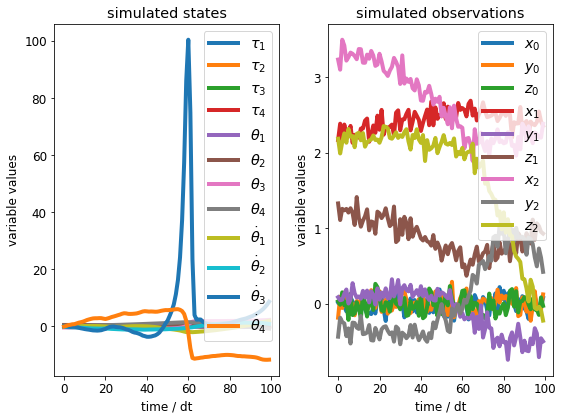

In [48]:
ind_in_batch = 2
arm_utils.plot_simulated_data(lat_data_np = lat_data_np,
                              sim_data_np = sim_data_np,
                              label_dict = label_dict_full,
                              ind_in_batch = ind_in_batch,
                             fig_full_path=plot_folder+'/sim.png')

below we define an iterator just too see how random chunks of the dataset look like. we define the iterator once and then can run `next()` multiple times to see the output.

In [97]:
test_gen_iter_test = iter(test_generator)
# https://stackoverflow.com/questions/30414246/why-iterator-next-returns-the-same-item-every-time

tensor([21600])
(9, 720)


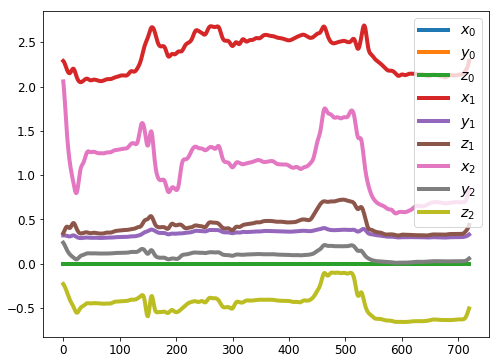

In [100]:
observations, t_ind_start = next(test_gen_iter_test)
print(t_ind_start)
obs_tensor = torch.cat([obs.unsqueeze(-1) for
                           obs in observations], dim=2)
obs_numpy = obs_tensor[0,:,:].cpu().numpy()
print(obs_numpy.shape)

plt.plot(obs_numpy.T); # plt.plot(single_dataset_arr.T);
plt.legend(label_dict_full["obs"])
plt.savefig(os.path.join(plot_folder, 'centered_data.png'))

In [89]:
# from scipy.special import logsumexp # sometimes needed

In [29]:
# import itertools
# def get_chained_params(*objects):
#     result = []
#     for object in objects:
#         if (object is not None) and isinstance(object, nn.Module):
#             result = itertools.chain(result, object.parameters())

#     if isinstance(result, list):
#         return None
#     else:
#         return result
    
# #print(list(get_chained_params(full_model["emission"], full_model["transition"])))
# pytorch_total_params = sum(p.numel() for p in full_model["emission"].parameters() if p.requires_grad)
# pytorch_total_params
# print(list(get_chained_params(full_model["emission"], full_model["transition"])))
# parameters = list(full_model["emission"].parameters())+ list(full_model["transition"].parameters())
# parameters=list(arm_model_instance.parameters())

Make sure the right parameter list is optimized:

In [101]:
#params_to_train = list(arm_model_instance.parameters())
params_to_train = list(full_model['proposal'].parameters())
print(params_to_train)

[Parameter containing:
tensor(2.6061, requires_grad=True), Parameter containing:
tensor(1.4860, requires_grad=True), Parameter containing:
tensor(0.0200, requires_grad=True), Parameter containing:
tensor(0.0100, requires_grad=True), Parameter containing:
tensor([[ 0.0820, -0.3219, -0.2308, -0.0260,  0.1101,  0.2074,  0.3047, -0.2249,
          0.3150],
        [ 0.2239, -0.2652, -0.2742, -0.2602,  0.0065, -0.0723, -0.3257, -0.0947,
          0.2088],
        [-0.0238, -0.2660, -0.2190,  0.1244,  0.1043, -0.1447, -0.2730,  0.1416,
         -0.1780],
        [-0.2920,  0.3057,  0.1340, -0.0566,  0.0489,  0.2707, -0.2962, -0.0663,
         -0.1180],
        [-0.3238,  0.2827, -0.3151, -0.1341,  0.1692,  0.3017, -0.0880,  0.2761,
         -0.0068],
        [-0.3081, -0.3107, -0.1549, -0.0020,  0.2704, -0.1424, -0.0517,  0.2279,
         -0.0822],
        [ 0.1444, -0.0283, -0.1299, -0.2160,  0.3272, -0.1790,  0.0343,  0.1158,
          0.0618],
        [-0.0269, -0.0644, -0.1403,  0.1152, 

In [105]:
# if you wanna train the whole model, not just do inference.
# If want to avoid the parameters argument, do instead, in the train_trackind_data func, list(parameters) and not just parameters.
# not sure that aesmc's package is doing the right thing here with the itertools. 
train.train_tracking_data(dataloader=test_generator,
                        num_particles = 500,
                        algorithm = 'aesmc',
                        model = full_model,
                        num_epochs=1,
                        parameters=params_to_train,
                        num_iterations_per_epoch=None,
                        callback=None)

[Parameter containing:
tensor(2.6061, requires_grad=True), Parameter containing:
tensor(1.4860, requires_grad=True), Parameter containing:
tensor(0.0200, requires_grad=True), Parameter containing:
tensor(0.0100, requires_grad=True), Parameter containing:
tensor([[ 0.0820, -0.3219, -0.2308, -0.0260,  0.1101,  0.2074,  0.3047, -0.2249,
          0.3150],
        [ 0.2239, -0.2652, -0.2742, -0.2602,  0.0065, -0.0723, -0.3257, -0.0947,
          0.2088],
        [-0.0238, -0.2660, -0.2190,  0.1244,  0.1043, -0.1447, -0.2730,  0.1416,
         -0.1780],
        [-0.2920,  0.3057,  0.1340, -0.0566,  0.0489,  0.2707, -0.2962, -0.0663,
         -0.1180],
        [-0.3238,  0.2827, -0.3151, -0.1341,  0.1692,  0.3017, -0.0880,  0.2761,
         -0.0068],
        [-0.3081, -0.3107, -0.1549, -0.0020,  0.2704, -0.1424, -0.0517,  0.2279,
         -0.0822],
        [ 0.1444, -0.0283, -0.1299, -0.2160,  0.3272, -0.1790,  0.0343,  0.1158,
          0.0618],
        [-0.0269, -0.0644, -0.1403,  0.1152, 

see how parameters changed.

In [106]:
params_to_train

[Parameter containing:
 tensor(2.6012, requires_grad=True),
 Parameter containing:
 tensor(1.4827, requires_grad=True),
 Parameter containing:
 tensor(0.0181, requires_grad=True),
 Parameter containing:
 tensor(0.0087, requires_grad=True),
 Parameter containing:
 tensor([[ 0.0820, -0.3219, -0.2308, -0.0283,  0.1078,  0.2055,  0.3029, -0.2264,
           0.3181],
         [ 0.2239, -0.2652, -0.2742, -0.2602,  0.0065, -0.0723, -0.3257, -0.0947,
           0.2088],
         [-0.0238, -0.2660, -0.2190,  0.1244,  0.1043, -0.1447, -0.2730,  0.1416,
          -0.1780],
         [-0.2920,  0.3057,  0.1340, -0.0566,  0.0489,  0.2707, -0.2962, -0.0663,
          -0.1180],
         [-0.3238,  0.2827, -0.3151, -0.1365,  0.1669,  0.2993, -0.0903,  0.2739,
          -0.0040],
         [-0.3081, -0.3107, -0.1549, -0.0020,  0.2704, -0.1424, -0.0517,  0.2279,
          -0.0822],
         [ 0.1444, -0.0283, -0.1299, -0.2160,  0.3272, -0.1790,  0.0343,  0.1158,
           0.0618],
         [-0.0269, -0.0

In [39]:
#list(arm_model_instance.parameters())

[Parameter containing:
 tensor(2.5692, requires_grad=True),
 Parameter containing:
 tensor(1.4628, requires_grad=True),
 Parameter containing:
 tensor(0.0084, requires_grad=True),
 Parameter containing:
 tensor(0.0074, requires_grad=True)]

In [56]:
full_model["transition"].arm_model.M2

Parameter containing:
tensor(0.0074, requires_grad=True)

In [40]:
inference_result = inference.infer_latents(full_model, 
                                 observations, 
                                 num_particles)

run time for 30 timesteps, 1 batches, 1000 particles = 1.17


In [41]:
inference_result = utils_summary.send_inference_result_to_cpu(inference_result)

In [42]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

applying uniform average of 1 SMC samplers.
applying weighted average of 1 SMC samplers.


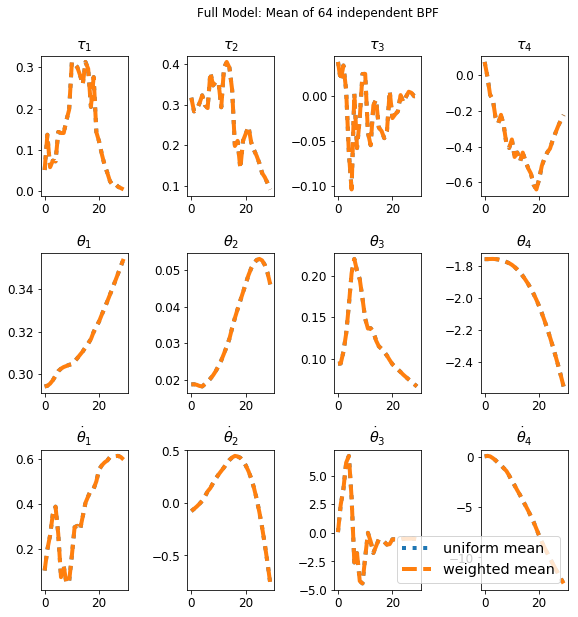

In [43]:
# comparison of uniform and weighted means
# uniform:
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  

# plot the two estimates.
f, axarr = plt.subplots(3, 4, figsize=(9, 9))
axarr = axarr.flatten()
for i in range(mean.shape[0]):
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == mean.shape[0] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/mean_of_64_filters.png')

NameError: name 'angles_np_0' is not defined

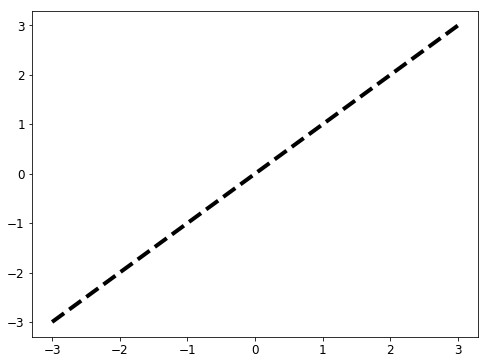

In [82]:
plt.plot([-3., 3.], [-3., 3.], 'k--', zorder=1)
plt.scatter(weighted_mean[[4,5,6,7],0], angles_np_0.reshape(4), color = 'blue', zorder=2, label = 'angles')
plt.scatter(weighted_mean[[8,9,10,11],0], init_velocity.reshape(4), color = 'red', zorder=3, label = 'velocities')
plt.xlabel('Inferred')
plt.ylabel('Initialized')
plt.legend()

independent SMC ESS: 1
(array([0]),)


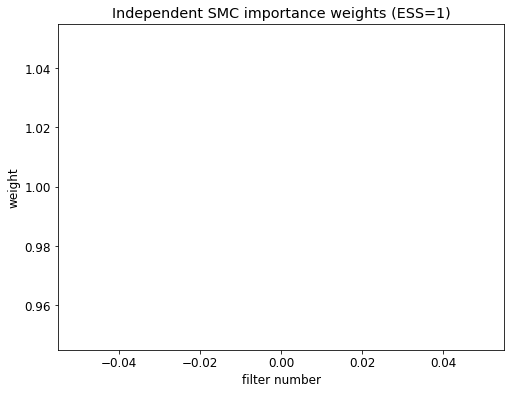

In [83]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
independent_SMC_ESS = 1.0 / np.sum(w**2)
print('independent SMC ESS: %d' % independent_SMC_ESS)
print(np.where(w==np.max(w)))
plt.ylabel('weight')
plt.xlabel('filter number')
plt.title('Independent SMC importance weights (ESS=%d)' % independent_SMC_ESS)
plt.savefig(os.path.join(plot_folder, 'ind_smc_importance_weights.png'))

In [1414]:
#np.sort(w) # note that many some w's are == 0. check that in future.

In [1415]:
# if you want indices of best and worst filters, run these lines.
#np.where(np.isin(w, np.sort(w)[-2:])) # which are the two best filters
#np.where(~np.isin(w, np.sort(w)[-2:])) # worst filters

In [1416]:
# # another version of the plot, incorporating variances.
# fig_full_path = plot_folder + '/uniform.png'
# nrows = 3
# num_latents = lat_data_np.shape[1]
# fig, axs = plt.subplots(nrows,
#                         int(num_latents / nrows),
#                         figsize=(16, 12),
#                         sharey=False)
# axs = axs.flatten()
# plt_leg = False
# for i in range(mean.shape[0]):
#     if i == num_latents-1:
#         plt_leg = True
#     arm_utils.plot_posterior_trace(
#     post_mean=mean[i,:],
#     post_var=np.sqrt(var[i,:]),
#     data_vec=lat_data_np[ind_in_batch, i, :],
#     alpha=0.5,
#     plot_legend=plt_leg,
#     plot_uncertainty=True,
#     plot_true_data=True,
#     legends_list=["inferred", "true"],
#     legend_loc="lower right",
#     title="Inferring latent " + label_dict_full["state"][i],
#     xlabel='Time',
#     ylabel='Amplitude',
#     fig_fullname=None,
#     ax=axs[i])
# fig.tight_layout()
# plt.savefig(fig_full_path)

In [1417]:
# # another version of the plot, incorporating variances.
# fig_full_path = plot_folder + '/weighted.png'
# nrows = 3
# num_latents = lat_data_np.shape[1]
# fig, axs = plt.subplots(nrows,
#                         int(num_latents / nrows),
#                         figsize=(16, 12),
#                         sharey=False)
# axs = axs.flatten()
# plt_leg = False
# for i in range(weighted_mean.shape[0]):
#     if i == num_latents-1:
#         plt_leg = True
#     arm_utils.plot_posterior_trace(
#     post_mean=weighted_mean[i,:],
#     post_var=np.sqrt(weighted_var[i,:]),
#     data_vec=lat_data_np[ind_in_batch, i, :],
#     alpha=0.5,
#     plot_legend=plt_leg,
#     plot_uncertainty=True,
#     plot_true_data=True,
#     legends_list=["inferred", "true"],
#     legend_loc="lower right",
#     title="Inferring latent " + label_dict_full["state"][i],
#     xlabel='Time',
#     ylabel='Amplitude',
#     fig_fullname=None,
#     ax=axs[i])
# fig.tight_layout()
# plt.savefig(fig_full_path)

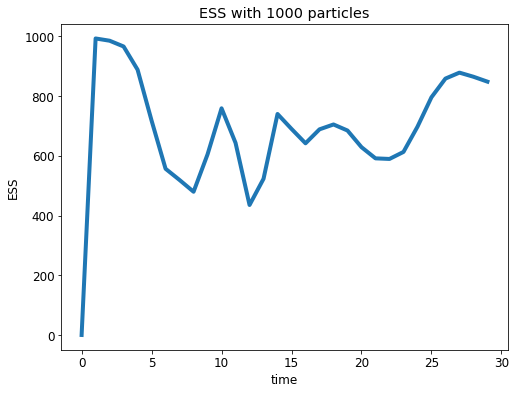

In [44]:
# plot ESS
ind_in_batch = 0
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

Reconstruct observations.

In [46]:
latent_result = torch.tensor(weighted_mean).expand(1,1,12,num_timesteps) # mean of independent SMC samplers
angles_in_time = latent_result[:,:,[4,5,6,7],:]

In [47]:
reconstructions = []
for i in range(latent_result.shape[-1]):
    reconstructions.append(full_model["emission"].FW_KIN_3D(
        angles_in_time[:, :, :, i]).view(1, 9))

In [48]:
recon_tensor = torch.cat([recon.unsqueeze(-1) for
                           recon in reconstructions], dim=2)
print(recon_tensor.shape)
recon_numpy = recon_tensor.squeeze(0).cpu().detach().numpy()

torch.Size([1, 9, 30])


In [49]:
# we're just doing this to verify that we're plotting the actual observations.
obs_tensor = torch.cat([obs.unsqueeze(-1) for
                           obs in observations], dim=2)
obs_numpy = obs_tensor[0,:,:].cpu().numpy()
obs_tensor.shape
#assert((obs_numpy == interpolated_single_dataset).all())

torch.Size([1, 9, 30])

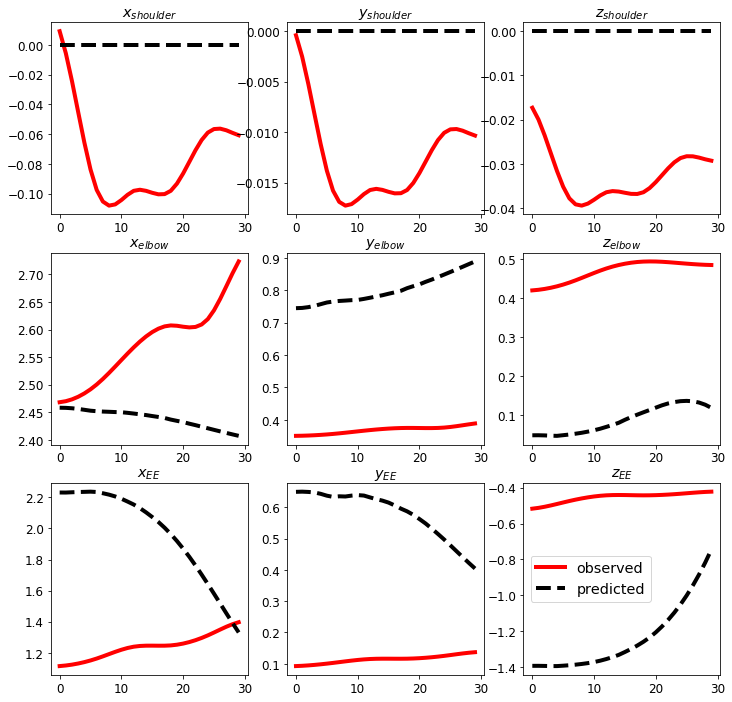

In [50]:
fig, axs = plt.subplots(3,3, figsize = (12,12))
axs = axs.flatten()
title_list_coords = [r"$x_{shoulder}$", r"$y_{shoulder}$", r"$z_{shoulder}$", 
                     r"$x_{elbow}$", r"$y_{elbow}$", r"$z_{elbow}$",
                    r"$x_{EE}$", r"$y_{EE}$", r"$z_{EE}$"]
for i in range(9):
    axs[i].plot(obs_numpy[i,:], 'r', label = 'observed')
    axs[i].plot(recon_numpy[i,:], 'k--', label = 'predicted')
    axs[i].set_title(title_list_coords[i])
axs[-1].legend();
plt.savefig(os.path.join(plot_folder, 'reconstructions.png'))

In [859]:
def arr3d_to_dict(arr):
    'convert n_frames by 9 array to a dict with x,y,z coords'
    dict_3d = {}
    dict_3d["x_coords"] = arr[:,[0, 3, 6]]
    dict_3d["y_coords"] = arr[:,[1, 4, 7]]
    dict_3d["z_coords"] = arr[:,[2, 5, 8]]
    return dict_3d

In [881]:
def plot_3d_points(coord_list_of_dicts,
                   lims_dict,
                   index,
                   color_list,
                   linestyle_list,
                   legend_list,
                   ax):
    '''plot a single frame
    ToDo: specify plotting patams, allow for multiple inputs'''
    
    assert(len(color_list)==len(coord_list_of_dicts))

    ax.set_xlim3d(lims_dict["x"])
    ax.set_ylim3d(lims_dict["y"])
    ax.set_zlim3d(lims_dict["z"])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    for i in range(len(coord_list_of_dicts)):
        ax.plot(coord_list_of_dicts[i]["x_coords"][index,:], \
                coord_list_of_dicts[i]["y_coords"][index,:], \
                coord_list_of_dicts[i]["z_coords"][index,:],
                linestyle = linestyle_list[i], 
                marker = 'o', 
                color = color_list[i], markersize=4, label = None)
    ax.legend(legend_list)

In [882]:
obs_dict = arr3d_to_dict(obs_numpy.T)
recon_dict = arr3d_to_dict(recon_numpy.T)
obs_dict['x_coords'].shape

(200, 3)

In [883]:
lims_dict = {}
lims_dict["x"] = (np.min(obs_dict["x_coords"]) - 0.5, np.max(obs_dict["x_coords"]) + 0.5)
lims_dict["y"] = (np.min(obs_dict["y_coords"]) - 0.5, np.max(obs_dict["y_coords"]) + 0.5)
lims_dict["z"] = (np.min(obs_dict["z_coords"]) - 0.5, np.max(obs_dict["z_coords"]) + 0.5)

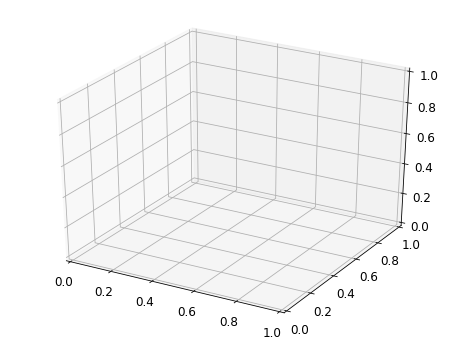

In [887]:
from mpl_toolkits.mplot3d import Axes3D 
image_folder = 'temp_images'
ax = plt.axes(projection='3d')
for i in range(obs_dict['x_coords'].shape[0]):
    plot_3d_points([obs_dict, recon_dict], lims_dict, i, ['black', 'red'], ['None', 'solid'],
                   ['DLC', 'Arm'], ax)
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')
    # clear both ax1 and ax2
    ax.cla()

make_video_from_images(image_folder=image_folder, 
                       save_name=os.path.join(plot_folder, 
                                              '3d_recon_costa_initial.avi'), 
                       fps = 50)

In [886]:
def make_video_from_images(image_folder, save_name, fps):
    # make video from these images
    import cv2
    import numpy as np
    import os
    im_list = os.listdir(image_folder)
    im_list.sort()
    im_list = im_list[1:]

    img_array = []
    for filename in im_list:
        img = cv2.imread(os.path.join(image_folder, filename))
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(save_name,
                          cv2.VideoWriter_fourcc(*'DIVX'), 
                          fps, size) # 15 fps

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

Smooth the results using the FFBS algorithm, the more `K_realizations`, the better.

In [778]:
# create a smoothing instance
from aesmc.smoothing import smooth_result
k_realizations = 20
smoothing_instance = smooth_result(full_model, 
                                   inference_result,
                                   k_realizations)
# run backward smoothing
smoothing_instance.run_backward_smoothing()

# summarize result (over k realizations)
smooth_mean, smooth_var = smoothing_instance.summarize()

print("shape of smooth_mean and smooth_var:")
print(smooth_mean.shape)

shape of smooth_mean and smooth_var:
(64, 12, 200)


In [780]:
# in the case of multiple independent samplers in the batch dimension
# otherwise, each batch contains its own data and no more summary is required.
weighted_smooth_mean, weighted_smooth_var = utils_summary.summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None) 

applying weighted average of 64 SMC samplers.


In [782]:
# latent_result = torch.tensor(weighted_mean).expand(1,1,12,num_timesteps_desired) # mean of independent SMC samplers
# angles_in_time = latent_result[:,:,[4,5,6,7],:]
# reconstructions_smoothed = []
# for i in range(latent_result.shape[-1]):
#     reconstructions_smoothed.append(full_model["emission"].FW_KIN_3D(
#         angles_in_time[:, :, :, i]).view(1, 9))
# recon_tensor = torch.cat([recon.unsqueeze(-1) for
#                            recon in reconstructions_smoothed], dim=2)
# print(recon_tensor.shape)
# recon_numpy = recon_tensor.squeeze(0).cpu().detach().numpy()
# fig, axs = plt.subplots(3,3, figsize = (12,12))
# axs = axs.flatten()
# title_list_coords = [r"$x_{shoulder}$", r"$y_{shoulder}$", r"$z_{shoulder}$", 
#                      r"$x_{elbow}$", r"$y_{elbow}$", r"$z_{elbow}$",
#                     r"$x_{EE}$", r"$y_{EE}$", r"$z_{EE}$"]
# for i in range(9):
#     axs[i].plot(interpolated_single_dataset[i,:], 'r', label = 'observed')
#     axs[i].plot(recon_numpy[i,:], 'k--', label = 'predicted')
#     axs[i].set_title(title_list_coords[i])
# axs[-1].legend();
# plt.savefig(os.path.join(plot_folder, 'reconstructions_smoothed.png'))

torch.Size([1, 9, 200])


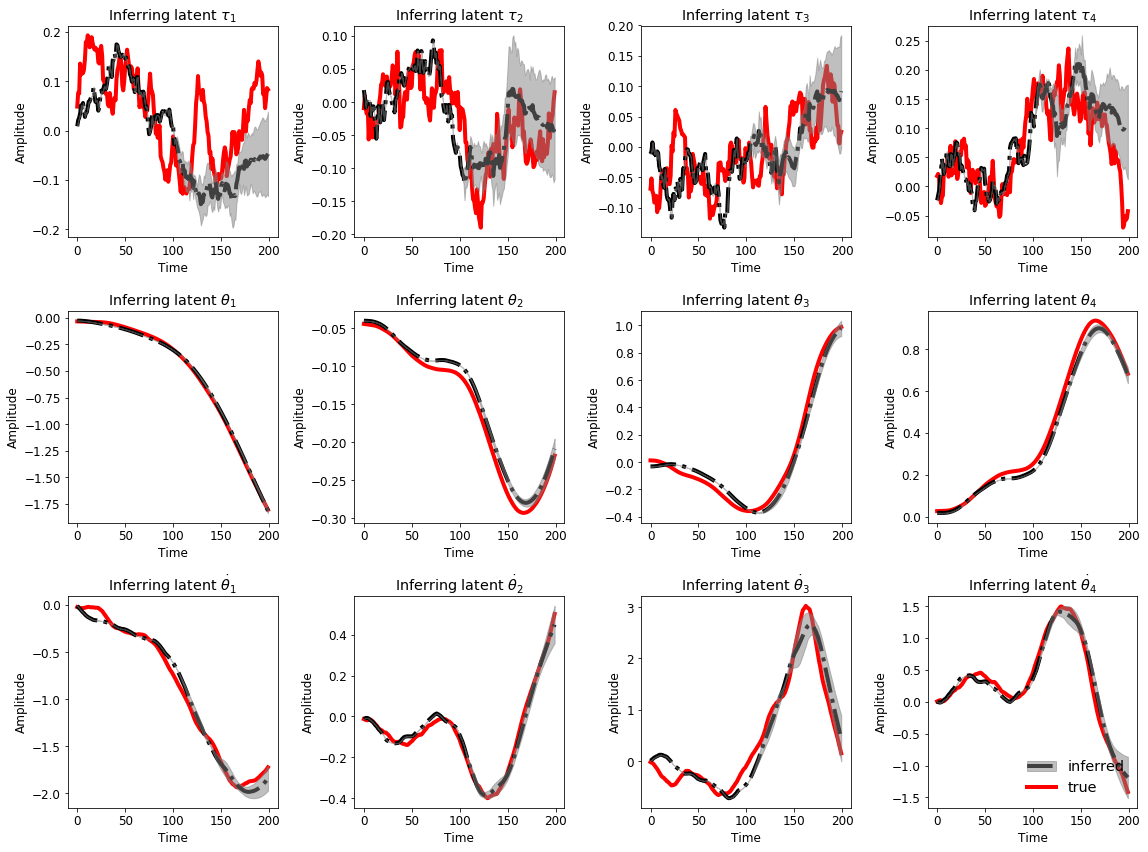

In [70]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/FFBS_BPF_infer_latents.png'
nrows = 3
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(16, 12),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_smooth_mean[i,:],
    post_var=np.sqrt(weighted_smooth_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

In [37]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


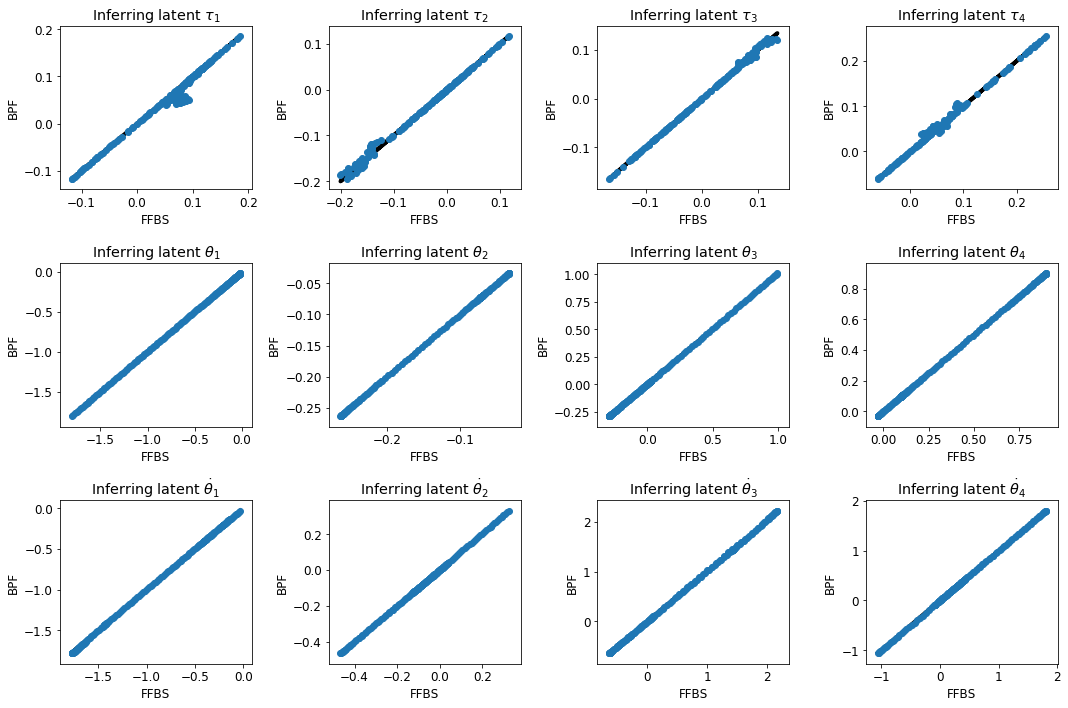

In [72]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 3
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('BPF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

In [ ]:
def train_tracking_data(dataloader,
                        num_particles,
                        algorithm,
                        model,
                        num_epochs,
                        num_iterations_per_epoch=None,
                        optimizer_algorithm=torch.optim.Adam,
                        optimizer_kwargs={},
                        callback=None):
    parameters = get_chained_params(model["initial"], model["transition"],
                                    model["emission"], model["proposal"])
    print('Training %i parameter groups' % len(parameters))
    optimizer = optimizer_algorithm(parameters, **optimizer_kwargs)
    for epoch_idx in range(num_epochs):
        #torch.manual_seed(0) # to make sure data loader repeats batches across epochs.
        for epoch_iteration_idx, (observations, t_ind_start) in enumerate(test_generator):
            if torch.sum(torch.isnan(torch.cat(observations))) > 0:
                continue
            if num_iterations_per_epoch is not None: # for simulated data.
                if epoch_iteration_idx == num_iterations_per_epoch:
                    break
            optimizer.zero_grad()
            loss = losses.get_loss(observations, num_particles, algorithm,
                                  model["initial"], model["transition"],
                                    model["emission"], model["proposal"])
            loss.backward()
            optimizer.step()

            if callback is not None:
                callback(epoch_idx, epoch_iteration_idx, loss, model["initial"], model["transition"],
                                    model["emission"], model["proposal"])

In [44]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] - sim_data_np[0, :2, :], axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] - sim_data_np[0, 2:4, :], axis=0)

In [48]:
(inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]

-0.003617780302634266

In [49]:
(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

-0.009406472491689799

In [52]:
# look at fw kin learning script for variables, etc.

2.0

In [22]:
learning_arm_params = False
if learning_arm_params:
    learning_inits_dict = {}
    learning_inits_dict['L1'] = inits_dict["L1"] + 0.5 # for now, can be empirical estimate or learned
    learning_inits_dict['L2'] = inits_dict["L1"] - 0.5 # same
    learning_inits_dict['M1'] = inits_dict["M1"] - 0.6 # test init for true == 1.1
    learning_inits_dict['M2'] = inits_dict["M2"] + 0.7 # test init for true == 1.1
else:
    learning_inits_dict = inits_dict
print(learning_inits_dict)

{'L1': 1.0, 'L2': 1.0, 'M1': 0.25, 'M2': 0.3}


In [23]:
arm_model_learning = arm_3d_dyn_model.Arm_3D_Dyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=learning_arm_params,
    restrict_to_plane=True) # Remove True in full model!

In [24]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(1.),
 Parameter containing:
 tensor(0.2500),
 Parameter containing:
 tensor(0.3000)]

In [25]:
param_dict
# ToDo: there are more params you can add to param dict?

{'init_mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'init_cov': array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]])}

In [26]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = arm_3d_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = arm_3d_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = arm_3d_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(9) *
                                                       emission_var_diag,
                                                       arm_model_learning,
                                                       theta_indices=[4,5,6,7])

learning_model["proposal"] = arm_3d_dyn_model.Learned_Proposal( \
                               learning_model["initial"], 
                                learning_model["transition"],
                                20)

In [27]:
num_timesteps

100

In [ ]:
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, initial, transition, emission, num_timesteps,
                 batch_size):
        self.initial = initial
        self.transition = transition
        self.emission = emission
        self.num_timesteps = num_timesteps
        self.batch_size = batch_size

    def __getitem__(self, index):
        # TODO this is wrong, obs can be dict
        return list(map(
            lambda observation: observation.detach().squeeze(0),
            statistics.sample_from_prior(self.initial, self.transition,
                                         self.emission, self.num_timesteps,
                                         self.batch_size)[1]))

    def __len__(self):
        return sys.maxsize  # effectively infinite


def get_synthetic_dataloader(initial, transition, emission, num_timesteps,
                             batch_size):
    return torch.utils.data.DataLoader(
        SyntheticDataset(initial, transition, emission, num_timesteps,
                         batch_size),
        batch_size=1,
        collate_fn=lambda x: x[0])

In [65]:
data = interpolated_data

In [130]:
floored = np.floor(data.shape[-1]/11)
#interpolated_data[:,11*16:].shape
arr_test = np.arange(0, 11*floored, 11)

In [132]:
#np.random.randint(0,10,2)
np.random.choice(arr_test, 2)

array([33., 55.])

In [142]:
import torch

data = interpolated_data

class Dataset(torch.utils.data.Dataset):
    '''Characterizes a dataset for PyTorch'''
    def __init__(self, data, num_timesteps, max_allowed_chunks):  # list_IDs
        '''Initialization:
        data: np.array of shape (dim_obs, many_timesteps)
        num_timesteps: number of time steps per sequence (chunk)'''
        self.data = data  # cheap to load one 9 by 100K arr.
        self.num_timesteps = int(num_timesteps)
        self.num_valid_chunks = int(
            np.floor(self.data.shape[-1] / self.num_timesteps)) # we won't necessary use them all. dep on max_allowed_chunks
        self.arr_start_IDs = np.arange(0,
                                       num_timesteps * self.num_valid_chunks,
                                       self.num_timesteps)  # not a list
        self.max_allowed_chunks = max_allowed_chunks
        if self.max_allowed_chunks < len(self.arr_start_IDs):
            self.arr_start_IDs = np.random.choice(self.arr_start_IDs,
                                                  size=self.max_allowed_chunks,
                                                 replace = False)
        # take the maximum of allowed chunks from data.

    def __len__(self):
        'Denotes the total number of samples. in our case, each sample is a time series.'
        return len(self.arr_start_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        start_ID = int(self.arr_start_IDs[index])

        # Load data and get label
        data_batch = self.data[:, start_ID:int(start_ID + self.num_timesteps)]
        batch_list = arm_utils.arr_to_list_of_tensors(
            data_batch, 1)  # 1 means that we do not repeat in batch.

        return batch_list, start_ID

In [143]:
dataset_test = Dataset(data, num_timesteps = 14, max_allowed_chunks=6)

In [144]:
print(dataset_test.num_valid_chunks)
print(len(dataset_test))

12
6


In [145]:
dataset_test.data.shape

(9, 180)

In [37]:
test_generator = torch.utils.data.DataLoader(dataset_test)

In [147]:
device = "cpu"
for local_batch, local_ID in test_generator:
    print(local_ID)
    # Transfer to GPU
    #local_batch, local_ID = local_batch.to(device), local_ID.to(device)

tensor([28])
tensor([84])
tensor([98])
tensor([140])
tensor([0])
tensor([42])


In [124]:
local_batch

[tensor([[[ 0.1286,  0.0147, -0.0163,  2.5812,  0.3669,  0.4449,  1.1481,
            0.1054, -0.4273]]], dtype=torch.float64),
 tensor([[[ 0.1285,  0.0147, -0.0160,  2.5810,  0.3669,  0.4448,  1.1486,
            0.1055, -0.4271]]], dtype=torch.float64),
 tensor([[[ 0.1275,  0.0145, -0.0160,  2.5809,  0.3669,  0.4448,  1.1492,
            0.1056, -0.4270]]], dtype=torch.float64),
 tensor([[[ 0.1252,  0.0142, -0.0164,  2.5810,  0.3669,  0.4449,  1.1499,
            0.1057, -0.4270]]], dtype=torch.float64),
 tensor([[[ 0.1221,  0.0138, -0.0171,  2.5812,  0.3669,  0.4450,  1.1508,
            0.1058, -0.4270]]], dtype=torch.float64),
 tensor([[[ 0.1186,  0.0133, -0.0179,  2.5816,  0.3670,  0.4452,  1.1515,
            0.1059, -0.4270]]], dtype=torch.float64),
 tensor([[[ 0.1152,  0.0127, -0.0186,  2.5821,  0.3671,  0.4455,  1.1521,
            0.1059, -0.4270]]], dtype=torch.float64),
 tensor([[[ 0.1122,  0.0123, -0.0191,  2.5827,  0.3672,  0.4458,  1.1524,
            0.1060, -0.4271]]]

In [28]:
# running params
num_timesteps = 100
saving_interval = 10
logging_interval = 1
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 10
num_particles = 500
num_epochs = 100

In [44]:
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [36]:
# ToDo: look at the aesmc original script for training
training_stats = arm_3d_dyn_model.TrainingStats(true_inits_dict=inits_dict,
                arm_model_instance = arm_model_learning,
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [29]:
arm_model_learning.to("cuda" if torch.cuda.is_available() else "cpu")

Arm_3D_Dyn()

In [30]:
# # just for now, but should be set . no need to run. can change defs here
# for param in list(arm_model_learning.parameters()):
#     parm.requires_grad = True
# print(list(arm_model_learning.parameters()))

In [31]:
from scipy.special import logsumexp

In [32]:
import itertools

def get_chained_params(*objects):
    result = []
    for object in objects:
        if (object is not None) and isinstance(object, nn.Module):
            result = itertools.chain(result, object.parameters())

    if isinstance(result, list):
        return None
    else:
        return result
    
def train_single_dataset(observations, num_particles, algorithm, initial, transition, emission,
          proposal, num_epochs, num_iterations_per_epoch=None,
          optimizer_algorithm=torch.optim.Adam, optimizer_kwargs={},
          callback=None):
    
    parameters = get_chained_params(initial, transition, emission, proposal)
    optimizer = optimizer_algorithm(parameters, **optimizer_kwargs)
    for epoch_idx in range(num_epochs):
        if torch.sum(torch.isnan(torch.cat(observations)))>0:
                continue
        optimizer.zero_grad()
        loss = losses.get_loss(observations, num_particles, algorithm,
                               initial, transition, emission, proposal)
        loss.backward()
        optimizer.step()
        
        print(loss.cpu().numpy())

In [37]:
train_single_dataset(observations = sim_observs,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=None)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.78 GiB total capacity; 14.35 GiB already allocated; 10.44 MiB free; 14.69 GiB reserved in total by PyTorch)

In [49]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.
each batch contains different data.


KeyboardInterrupt: 

In [50]:
# debug nans in the dataloader
num_iterations_per_epoch = num_iterations
for epoch_idx in range(num_epochs):
    torch.manual_seed(0) # to make sure data loader repeats batches across epochs.
    for epoch_iteration_idx, observations in enumerate(dataloader):
        nan_counts = np.sum(np.isnan(torch.cat(observations).cpu().numpy()))
        if nan_counts>0:
            print(nan_counts)
        if num_iterations_per_epoch is not None:
            if epoch_iteration_idx == num_iterations_per_epoch:
                break

each batch contains different data.
240
each batch contains different data.
198
each batch contains different data.
252
each batch contains different data.
252
each batch contains different data.
306
each batch contains different data.
162
each batch contains different data.
210
each batch contains different data.
198
each batch contains different data.
102
each batch contains different data.
264
each batch contains different data.
198
each batch contains different data.
240
each batch contains different data.
198
each batch contains different data.
252
each batch contains different data.
252
each batch contains different data.
306
each batch contains different data.
162
each batch contains different data.
210
each batch contains different data.
198
each batch contains different data.


KeyboardInterrupt: 

In [33]:
training_stats.curr_params_list

[array([2.49700022, 1.49699986, 0.49700004, 1.89699984]),
 array([2.49400926, 1.49793363, 0.4989669 , 1.89731312]),
 array([2.49107742, 1.49938333, 0.50068009, 1.89818633]),
 array([2.488065  , 1.50084352, 0.50290495, 1.89820015]),
 array([2.4851253 , 1.50281751, 0.50551438, 1.90007496]),
 array([2.48240852, 1.50460708, 0.50689256, 1.90183008]),
 array([2.47966623, 1.50586808, 0.50735027, 1.90305948]),
 array([2.47681284, 1.50688112, 0.50774562, 1.90401912]),
 array([2.47378564, 1.50753689, 0.50755501, 1.90464509]),
 array([2.47074509, 1.50797939, 0.50734842, 1.90505576]),
 array([2.46790624, 1.50833714, 0.50741404, 1.90537548]),
 array([2.4668138 , 1.50765264, 0.50564218, 1.90488935]),
 array([2.4658637 , 1.50678515, 0.50434196, 1.90419471]),
 array([2.46639371, 1.50420797, 0.50180221, 1.90163028]),
 array([2.46706963, 1.50164759, 0.49926013, 1.8990767 ]),
 array([2.4672091 , 1.49973607, 0.49735665, 1.89717078]),
 array([2.4668169 , 1.49832559, 0.49593547, 1.89576614]),
 array([2.4659

In [36]:
learning_model["proposal"]

Learned_Proposal(
  (transition): Transition(
    (arm_model): Arm_3D_Dyn()
  )
  (FF_mu): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
  )
  (FF_var): Sequential(
    (0): Linear(in_features=9, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [34]:
params = np.asarray(training_stats.curr_params_list)
print(params)

[[2.49700022 1.49699986 0.49700004 1.89699984]
 [2.49400926 1.49793363 0.4989669  1.89731312]
 [2.49107742 1.49938333 0.50068009 1.89818633]
 ...
 [2.16396403 1.48020077 0.50613308 1.86156929]
 [2.16436934 1.4805733  0.50662583 1.86199868]
 [2.16406298 1.48040545 0.5069297  1.8618288 ]]


$M_1 : = 1, M_2 = \lambda \cdot M_1$ 
since we can init $L$ properly from observations, maybe fix $L$'s and $M_1$ -- can we infer $M_2$?
If this becomes hard, just fix all params and ignore the learning problem.

In [49]:
L1_in_training  = np.zeros(len(training_stats.curr_params_list))
L2_in_training  = np.zeros(len(training_stats.curr_params_list))

for i in range(len(training_stats.curr_params_list)):
    L1_in_training[i] = training_stats.curr_params_list[i][0]
    L2_in_training[i] = training_stats.curr_params_list[i][1]

NameError: name 'L1_in_training' is not defined

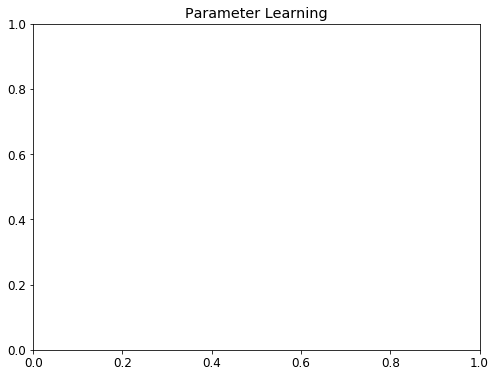

In [57]:
plt.title('Parameter Learning')
plt.plot(L1_in_training, label = r"$L_1$")
plt.plot(L2_in_training, label = r"$L_2$")
plt.plot([0, len(L1_in_training)], [2.0, 2.0], 'k', label = "True length")
plt.xlabel('training_iteration/10')
plt.legend()

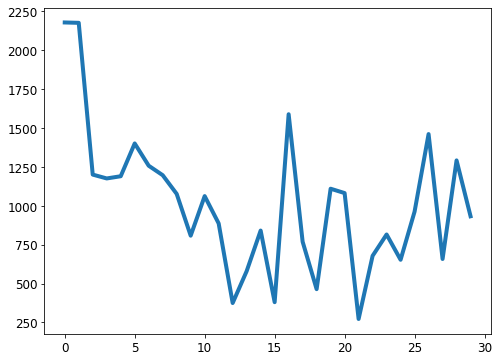

In [56]:
plt.plot(training_stats.loss)

If I want to implement an RNN in my learned proposal. I think it's a good idea.
better to try lstm https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

In [1148]:
rnn = torch.nn.RNN(input_size = 9, hidden_size=50, nonlinearity = 'tanh', batch_first = True)

In [1149]:
input_tensor = torch.randn(batch_size, num_timesteps_desired, 9).type(torch.float)
g=1.0
h0 = torch.tensor(np.random.normal(loc=0, scale = g/np.sqrt(50), size = (1, batch_size, 50))).type(torch.float)
#output, hn = rnn(input_tensor, )

In [1150]:
output, hn = rnn(input_tensor, h0)

torch.Size([64, 200, 50])
torch.Size([1, 64, 50])


torch.Size([64, 200, 6])

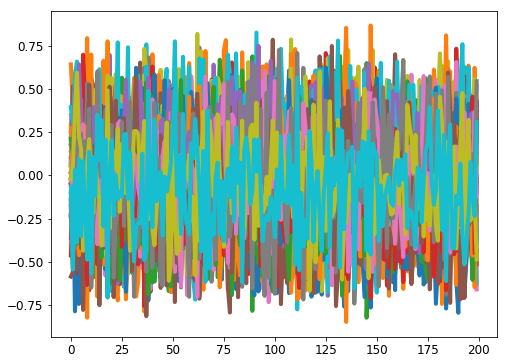

In [1154]:
print(output.shape)
print(hn.shape)
plt.plot(output.cpu().detach().numpy()[0,:,:]);
w_out = torch.randn(50,6) # can have one readout for mu, and one readout for sigma. can have it biderectional.
readout = output.matmul(w_out)
readout.shape

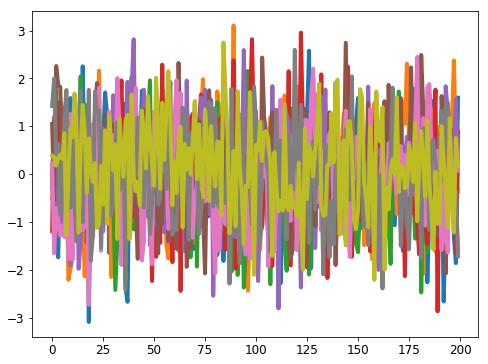

In [1153]:
plt.plot(input_tensor.cpu().detach().numpy()[0,:,:]);